<a href="https://colab.research.google.com/github/mridulan0/COVID-Viral-Pneumonia-AI-Detection/blob/main/resnet50_vgg19_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
resnet50_full_model.save_weights('resnet50_b16_bestweights.hdf5')
vgg19_full_model.save_weights('vgg19_b16_bestweights.hdf5')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import backend as k
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, model_from_json
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation, Flatten, Dense, BatchNormalization, ZeroPadding2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# google drive
from google.colab import drive
drive.mount("/content/drive") #fill the inside

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Science Fair/Synopsis Science Fair Project 2021/Dataset_-20210215T213906Z-001.zip" #fill the inside

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_/COVID-19/COVID (131).png  
  inflating: Dataset_/COVID-19/COVID (562).png  
  inflating: Dataset_/COVID-19/COVID (627).png  
  inflating: Dataset_/COVID-19/COVID (522).png  
  inflating: Dataset_/COVID-19/COVID (236).png  
  inflating: Dataset_/COVID-19/COVID (174).png  
  inflating: Dataset_/COVID-19/COVID (260).png  
  inflating: Dataset_/COVID-19/COVID (2).png  
  inflating: Dataset_/COVID-19/COVID (165).png  
  inflating: Dataset_/COVID-19/COVID (303).png  
  inflating: Dataset_/COVID-19/COVID (149).png  
  inflating: Dataset_/COVID-19/COVID (16).png  
  inflating: Dataset_/COVID-19/COVID (404).png  
  inflating: Dataset_/COVID-19/COVID (42).png  
  inflating: Dataset_/COVID-19/COVID (38).png  
  inflating: Dataset_/COVID-19/COVID (497).png  
  inflating: Dataset_/COVID-19/COVID (466).png  
  inflating: Dataset_/COVID-19/COVID (469).png  
  inflating: Dataset_/COVID-19/COVID (571).png  
  inflating: Dataset_/C

In [ ]:
# folders for train and test
!mkdir test
!mkdir train
!mkdir "train/Normal"
!mkdir "train/COVID-19"
!mkdir "train/Bacterial Pneumonia"
!mkdir "train/Non-COVID Viral Pneumonia"
!mkdir "test/Normal"
!mkdir "test/COVID-19"
!mkdir "test/Bacterial Pneumonia"
!mkdir "test/Non-COVID Viral Pneumonia"

In [ ]:
IMG_PATH = 'Dataset_/'

print(IMG_PATH)

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
      dir  = os.path.isdir(IMG_PATH + CLASS)
      if dir:
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 0.8*IMG_NUM:
                shutil.copy(img, 'train/' + CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'test/'+ CLASS + '/' + FILE_NAME)

Dataset_/


In [ ]:
# dimensions of our images
img_width, img_height = 224, 224
img_size = (224, 224)

# Saving the batch_size and epochs for training to variables
batch_size = 64 #usually in powers of 2 - 8, 16, 32, 64, 128
epochs = 50
lr = 0.0001
class_array = ['Normal', 'COVID-19', 'Non-COVID Viral Pneumonia']
num_classes = len(class_array)

train_file_count = sum(len(files) for _, _, files in os.walk(r'train'))
test_file_count = sum(len(files) for _, _, files in os.walk(r'test'))

print("Number of files in train set ", train_file_count)
print("Number of files in test set ", test_file_count)

Number of files in train set  6744
Number of files in test set  1684


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.15,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 0.1)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.15)

In [ ]:
train_generator = train_datagen.flow_from_directory('train',
                                                    subset = 'training',shuffle = True,
                                                    seed = 42,
                                                    target_size = img_size,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    classes = class_array)

validation_generator = valid_datagen.flow_from_directory('train',
                                                         subset = 'validation',
                                                         seed = 42,
                                                         target_size = img_size,
                                                         batch_size = batch_size,
                                                         class_mode = 'categorical',
                                                         classes = class_array)

Found 4136 images belonging to 3 classes.
Found 728 images belonging to 3 classes.


### ResNet50

In [ ]:
from keras.applications.resnet import ResNet50

resnet_pre_trained_model = ResNet50(input_shape = (224,224,3),
                                    include_top = False,
                                    weights = 'imagenet')

for layer in resnet_pre_trained_model.layers:
  layer.trainable = False

resnet_pre_trained_model.summary()

94773248/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
def build_model(model_name):
  new_model = Sequential()
  model = model_name
  new_model.add(model)
  new_model.add(Flatten())
  new_model.add(Dense(64, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(32, activation='relu'))
  new_model.add(Dropout(0.3))
  new_model.add(Dense(16, activation='relu'))
  new_model.add(Dropout(0.1))
  new_model.add(Dense(num_classes, activation='softmax'))
  return new_model

my_resnet = build_model(resnet_pre_trained_model)

my_resnet.summary()

my_model = my_resnet

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                5

In [ ]:
optimizer = Adam(lr = lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

weight_path="resnet50_b64_bestweights.hdf5".format('class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss',
                      mode = 'auto',
                      patience = 10)

callbacks_list = [checkpoint, early]
print(callbacks_list)

[<tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f776822d710>, <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f776822d6d0>]


In [ ]:
my_resnet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = my_resnet.fit(train_generator,
                       validation_data = validation_generator,
                       epochs = epochs,
                       batch_size = batch_size,
                       callbacks = callbacks_list)

Epoch 1/50
65/65 [==============================] - 111s 2s/step - loss: 1.1665 - accuracy: 0.3705 - val_loss: 1.0438 - val_accuracy: 0.3805

Epoch 00001: val_loss improved from inf to 1.04379, saving model to resnet50_b64_bestweights.hdf5
Epoch 2/50
65/65 [==============================] - 103s 2s/step - loss: 1.0538 - accuracy: 0.4016 - val_loss: 0.9995 - val_accuracy: 0.3860

Epoch 00002: val_loss improved from 1.04379 to 0.99948, saving model to resnet50_b64_bestweights.hdf5
Epoch 3/50
65/65 [==============================] - 103s 2s/step - loss: 1.0282 - accuracy: 0.4199 - val_loss: 0.9697 - val_accuracy: 0.4148

Epoch 00003: val_loss improved from 0.99948 to 0.96972, saving model to resnet50_b64_bestweights.hdf5
Epoch 4/50
65/65 [==============================] - 103s 2s/step - loss: 1.0225 - accuracy: 0.4485 - val_loss: 0.9446 - val_accuracy: 0.4121

Epoch 00004: val_loss improved from 0.96972 to 0.94460, saving model to resnet50_b64_bestweights.hdf5
Epoch 5/50
65/65 [==========

In [ ]:
ResNet50_model_json = my_resnet.to_json()
with open("model.json", "w") as json_file:
    json_file.write(ResNet50_model_json)

# serialize weights to HDF5
my_resnet.save_weights("model.h5")
print("Saved model to disk")

# save model and architecture to single file
my_resnet.save("my_resnet50_model_b64.h5")
print("Saved full model to disk")

Saved model to disk
Saved full model to disk


In [ ]:
from keras.models import load_model #to load the model saved as a h5 file
# load model
resnet50_full_model = build_model(resnet_pre_trained_model)

resnet50_full_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

resnet50_full_model.load_weights('resnet50_b64_bestweights.hdf5')
# summarize model.
resnet50_full_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


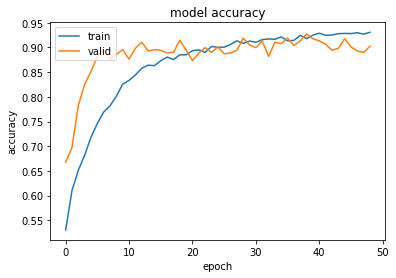

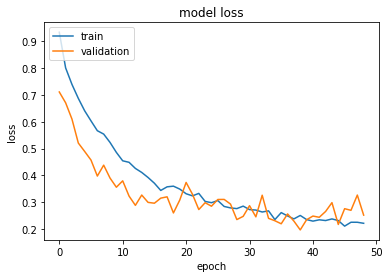

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Found 1214 images belonging to 3 classes.
1214/1214 [==============================] - 22s 18ms/step - loss: 0.6580 - accuracy: 0.6878
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       462
           1       0.00      0.00      0.00       258
           2       0.58      0.88      0.70       494

    accuracy                           0.69      1214
   macro avg       0.48      0.58      0.52      1214
weighted avg       0.57      0.69      0.61      1214

accuracy:  0.6878088962108732
[[401   0  61]
 [  1   0 257]
 [ 60   0 434]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


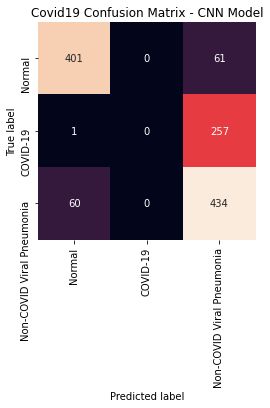

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory('test',
                                                  target_size = img_size,
                                                  batch_size = 1,
                                                  shuffle = False,
                                                  classes = class_array)

my_resnet.evaluate(test_generator)

from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
y_true = test_generator.classes
probabilities = my_resnet.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

1214/1214 [==============================] - 24s 18ms/step - loss: 0.5234 - accuracy: 0.7490
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       462
           1       0.00      0.00      0.00       258
           2       0.58      0.88      0.70       494

    accuracy                           0.69      1214
   macro avg       0.48      0.58      0.52      1214
weighted avg       0.57      0.69      0.61      1214

accuracy:  0.6878088962108732
[[401   0  61]
 [  1   0 257]
 [ 60   0 434]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


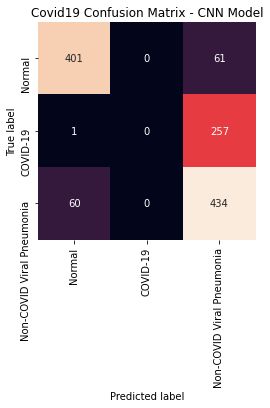

In [ ]:
resnet50_full_model.evaluate(test_generator)

y_true = test_generator.classes
probabilities = resnet50_full_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###VGG-19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

VGG19_pre_trained_model = VGG19(input_shape = (224,224,3),
                              include_top = False,
                              weights = 'imagenet')

for layer in VGG19_pre_trained_model.layers:
    layer.trainable = False

VGG19_pre_trained_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
def build_model(model_name):
  new_model = Sequential()
  model = model_name
  new_model.add(model)
  new_model.add(Flatten())
  new_model.add(Dense(64, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(32, activation='relu'))
  new_model.add(Dropout(0.3))
  new_model.add(Dense(16, activation='relu'))
  new_model.add(Dropout(0.1))
  new_model.add(Dense(num_classes, activation='softmax'))
  return new_model

my_vgg19_model = build_model(VGG19_pre_trained_model)

my_vgg19_model.summary()

my_model = my_vgg19_model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)               

In [ ]:
optimizer = Adam(lr = lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

weight_path="vgg19_b64_bestweights.hdf5".format('class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_weights_only = True)

early = EarlyStopping(monitor = 'val_loss',
                      mode = 'auto',
                      patience = 10)

callbacks_list = [checkpoint, early]
print(callbacks_list)

[<tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f754656d410>, <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f754656d4d0>]


In [ ]:
my_vgg19_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = my_vgg19_model.fit(train_generator,
                       validation_data = validation_generator,
                       epochs = epochs,
                       batch_size = batch_size,
                       callbacks = callbacks_list)

Epoch 1/50
65/65 [==============================] - 105s 2s/step - loss: 1.0105 - accuracy: 0.4708 - val_loss: 0.7108 - val_accuracy: 0.6676

Epoch 00001: val_loss improved from inf to 0.71076, saving model to vgg19_b64_bestweights.hdf5
Epoch 2/50
65/65 [==============================] - 102s 2s/step - loss: 0.8185 - accuracy: 0.5995 - val_loss: 0.6705 - val_accuracy: 0.6978

Epoch 00002: val_loss improved from 0.71076 to 0.67047, saving model to vgg19_b64_bestweights.hdf5
Epoch 3/50
65/65 [==============================] - 103s 2s/step - loss: 0.7647 - accuracy: 0.6442 - val_loss: 0.6097 - val_accuracy: 0.7830

Epoch 00003: val_loss improved from 0.67047 to 0.60971, saving model to vgg19_b64_bestweights.hdf5
Epoch 4/50
65/65 [==============================] - 103s 2s/step - loss: 0.6935 - accuracy: 0.6783 - val_loss: 0.5207 - val_accuracy: 0.8255

Epoch 00004: val_loss improved from 0.60971 to 0.52070, saving model to vgg19_b64_bestweights.hdf5
Epoch 5/50
65/65 [======================

In [ ]:
VGG19_model_json = my_vgg19_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(VGG19_model_json)

# serialize weights to HDF5
my_vgg19_model.save_weights("model.h5")
print("Saved model to disk")

# save model and architecture to single file
my_vgg19_model.save("my_vgg19_model_b64.h5")
print("Saved full model to disk")

Saved model to disk
Saved full model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


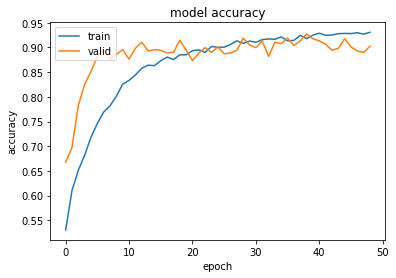

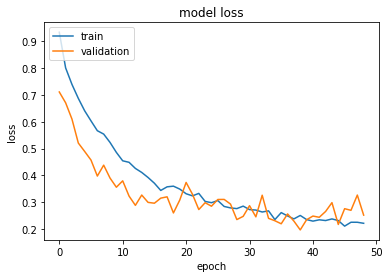

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model #to load the model saved as a h5 file
# load model
vgg19_full_model = build_model(VGG19_pre_trained_model)

vgg19_full_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

vgg19_full_model.load_weights('vgg19_b64_bestweights.hdf5')
# summarize model.
vgg19_full_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)               

1214/1214 [==============================] - 20s 16ms/step - loss: 0.2130 - accuracy: 0.9259
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       462
           1       0.97      0.97      0.97       258
           2       0.97      0.86      0.91       494

    accuracy                           0.93      1214
   macro avg       0.94      0.93      0.93      1214
weighted avg       0.93      0.93      0.93      1214

accuracy:  0.9258649093904449
[[448   5   9]
 [  4 251   3]
 [ 66   3 425]]


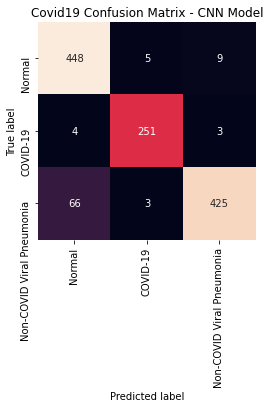

In [ ]:
my_vgg19_model.evaluate(test_generator)

y_true = test_generator.classes
probabilities = my_vgg19_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

1214/1214 [==============================] - 20s 17ms/step - loss: 0.1346 - accuracy: 0.9659
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       462
           1       0.96      0.98      0.97       258
           2       0.96      0.91      0.94       494

    accuracy                           0.94      1214
   macro avg       0.95      0.95      0.95      1214
weighted avg       0.94      0.94      0.94      1214

accuracy:  0.943986820428336
[[442   5  15]
 [  3 253   2]
 [ 38   5 451]]


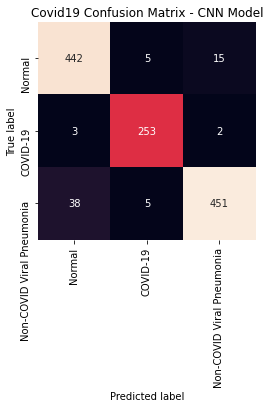

In [ ]:
vgg19_full_model.evaluate(test_generator)

y_true = test_generator.classes
probabilities = vgg19_full_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
!cp resnet50_b64_bestweights.hdf5 "/content/drive/MyDrive/Science Fair"
!cp vgg19_b64_bestweights.hdf5 "/content/drive/MyDrive/Science Fair"

!cp my_resnet50_model_b64.h5 "/content/drive/MyDrive/Science Fair"
!cp my_vgg19_model_b64.h5 "/content/drive/MyDrive/Science Fair"

In [ ]:
#!cp my_resnet50_model_b32.h5 "/content/drive/MyDrive/Science Fair"